# B-spline interpolation task

Notebook showing a workflow example implementing the interpolation of time-series using B-splines

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Create-workflow-for-downloading-data" data-toc-modified-id="1.-Create-workflow-for-downloading-data-1">1. Create workflow for downloading data</a></span></li><li><span><a href="#2.-Load-and-plot-original-data-from-disk" data-toc-modified-id="2.-Load-and-plot-original-data-from-disk-2">2. Load and plot original data from disk</a></span></li><li><span><a href="#3.-Interpolating-data" data-toc-modified-id="3.-Interpolating-data-3">3. Interpolating data</a></span></li></ul></div>

In [1]:
%matplotlib inline

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sentinelhub import BBox, CRS, DataCollection

from eolearn.core import LinearWorkflow, EOTask, EOPatch, FeatureType, SaveTask, LoadTask, OverwritePermission
from eolearn.io import SentinelHubInputTask
from eolearn.mask import AddValidDataMaskTask
from eolearn.features import BSplineInterpolation, NormalizedDifferenceIndexTask

## 1. Create workflow for downloading data

This workflow consists of the following EOTasks:
- download data
- calculate NDVI
- create mask of valid data (no clouds, no `NaN`s due to no data)

The cloud masks are downloaded via the `CLM` bands. More info [here](https://docs.sentinel-hub.com/api/latest/#/API/data_access?id=cloud-masks-and-cloud-probabilities).

In [2]:
# download data
add_data_task = SentinelHubInputTask(
    data_collection = DataCollection.SENTINEL2_L1C, 
    bands_feature=(FeatureType.DATA, 'BANDS-S2-L1C'),
    time_difference = timedelta(hours=2),
    resolution=10,
    additional_data = [
        (FeatureType.MASK, 'CLM'),
        (FeatureType.DATA, 'CLP'),
        (FeatureType.MASK, 'dataMask'),
    ]
)

# calculate NDVI
ndvi_task = NormalizedDifferenceIndexTask(
    input_feature=(FeatureType.DATA, 'BANDS-S2-L1C'),
    output_feature=(FeatureType.DATA, 'NDVI'),
    bands = [7,2]    
)

# this function merges the `IS_DATA` and the `CLM` masks
class ValidDataPredicate:
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['dataMask'].astype(np.bool), 
                              np.logical_not((eopatch.mask['CLM'] != 0).astype(np.bool)))

# add valid data mask
add_valmask_task = AddValidDataMaskTask(predicate=ValidDataPredicate())

# save eopatch data
save_task = SaveTask('./data', overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

Run workflow and save the EOPatch to disk (for easier experimentation)

In [3]:
workflow = LinearWorkflow(
    add_data_task,
    ndvi_task,
    add_valmask_task,
    save_task
)

In [4]:
# define ROI BBOX and time interval
roi_bbox = BBox([-116.07124, 33.55431, -116.01335, 33.58277], crs=CRS.WGS84)
time_interval = ('2019-01-01', '2019-12-31')

In [5]:
result = workflow.execute({
    add_data_task: {'bbox': roi_bbox, 'time_interval': time_interval},
    save_task: {'eopatch_folder': 'patch'}
})

## 2. Load and plot original data from disk

In [6]:
eop_orig = EOPatch.load('./data/patch/')
eop_orig

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(73, 321, 534, 13), dtype=float32)
    CLP: numpy.ndarray(shape=(73, 321, 534, 1), dtype=uint8)
    NDVI: numpy.ndarray(shape=(73, 321, 534, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(73, 321, 534, 1), dtype=uint8)
    VALID_DATA: numpy.ndarray(shape=(73, 321, 534, 1), dtype=bool)
    dataMask: numpy.ndarray(shape=(73, 321, 534, 1), dtype=uint8)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1.0
    service_type: 'processing'
    size_x: 534
    size_y: 321
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ('2019-01-01T00:00:00', '2019-12-31T23:59:59')
  }
  bbox: BBox(((-116.07124, 33.55431), (-116.01335, 33.58277)), crs=CRS('4326'))
  timestamp: [datetime.datetime(2019, 1, 1, 18, 34, 53), ..., datetime.datetime(2019, 12, 27, 18, 34, 54)], length=73
)

In [7]:
def plot(patch, timestamp_idx):
    """
    Utility function for plotting
    """
    subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': False}
    fig, axs = plt.subplots(2,2,figsize=(15,10), subplot_kw=subplot_kw)
    
    ax = axs[0,0]
    ax.imshow(patch.data['BANDS-S2-L1C'][timestamp_idx, :, :, 3:0:-1] * 2.)
    ax.set_title('True color',fontsize=15)
    
    ax = axs[0,1]
    im1 = ax.imshow(patch.data['NDVI'][timestamp_idx].squeeze(), vmin=-0.2, vmax=0.8)
    ax.set_title('NDVI',fontsize=15)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    fig.colorbar(im1, cax=cax)
    
    ax = axs[1,0]
    ax.imshow(patch.mask['VALID_DATA'][timestamp_idx].squeeze(),cmap=plt.cm.inferno,vmin=0,vmax=1)
    ax.set_title('Valid data mask',fontsize=15)
    
    ax = axs[1,1]
    im2 = ax.imshow(patch.data['CLP'][timestamp_idx,...,0]/255,cmap=plt.cm.inferno,vmin=0,vmax=1)
    ax.set_title('CLP values',fontsize=15)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    fig.colorbar(im2, cax=cax)
    
    plt.tight_layout()

In [8]:
# stats for all ndvi data
mean_ndvi_all = np.nanmean(eop_orig.data['NDVI'],axis=(1,2))
std_ndvi_all  = np.nanstd(eop_orig.data['NDVI'],axis=(1,2))

In [9]:
# stats for valid ndvi data
mask = eop_orig.mask['VALID_DATA'] == 0
masked_ndvi_orig = ma.masked_array(eop_orig.data['NDVI'], mask=mask)
mean_ndvi_valid = ma.mean(masked_ndvi_orig, axis=(1,2))
std_ndvi_valid  = ma.std(masked_ndvi_orig, axis=(1,2))

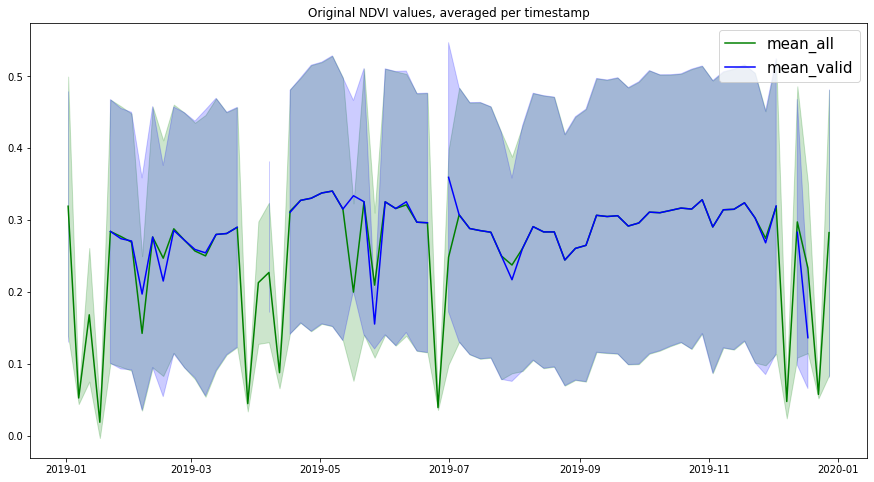

In [10]:
fig = plt.figure(figsize=(15,8))

plt.plot(eop_orig.timestamp, mean_ndvi_all,color='g', label='mean_all')
plt.fill_between(eop_orig.timestamp, mean_ndvi_all.squeeze()+std_ndvi_all.squeeze(),mean_ndvi_all.squeeze()-std_ndvi_all.squeeze(),alpha=0.2,color='g')

plt.plot(eop_orig.timestamp, mean_ndvi_valid,color='b', label='mean_valid')
plt.fill_between(eop_orig.timestamp, mean_ndvi_valid.squeeze()+std_ndvi_valid.squeeze(),mean_ndvi_valid.squeeze()-std_ndvi_valid.squeeze(),alpha=0.2,color='b')

plt.legend(fontsize=15)
plt.title('Original NDVI values, averaged per timestamp');

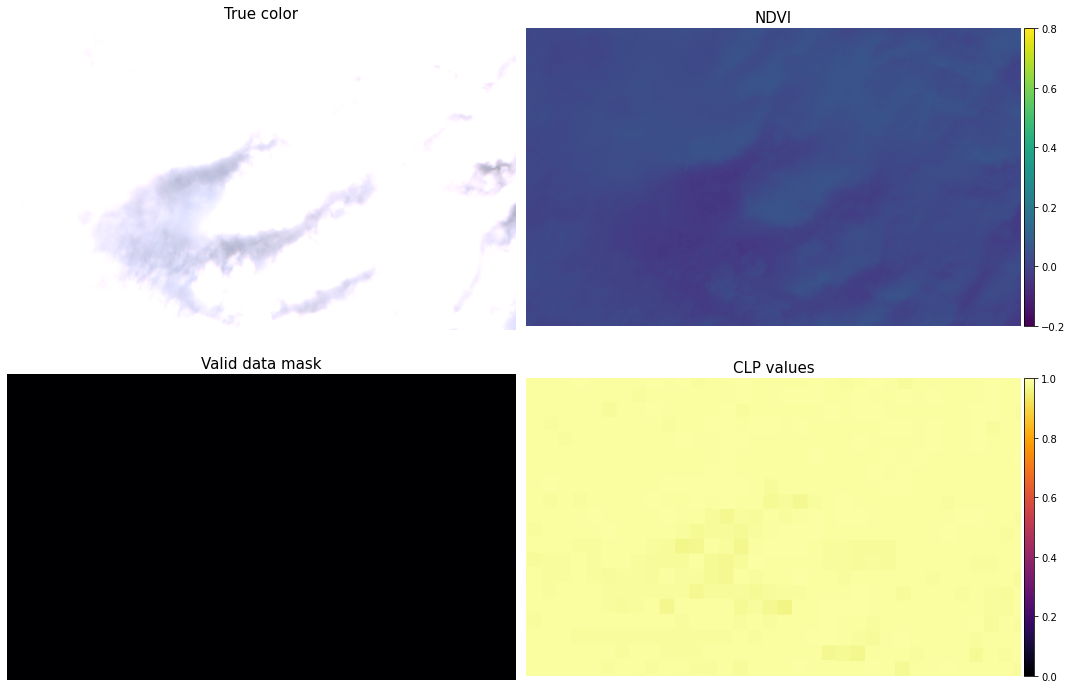

In [11]:
plot(eop_orig, np.argmin(mean_ndvi_all))

In [12]:
eop_orig.timestamp[-7]

datetime.datetime(2019, 11, 27, 18, 34, 59)

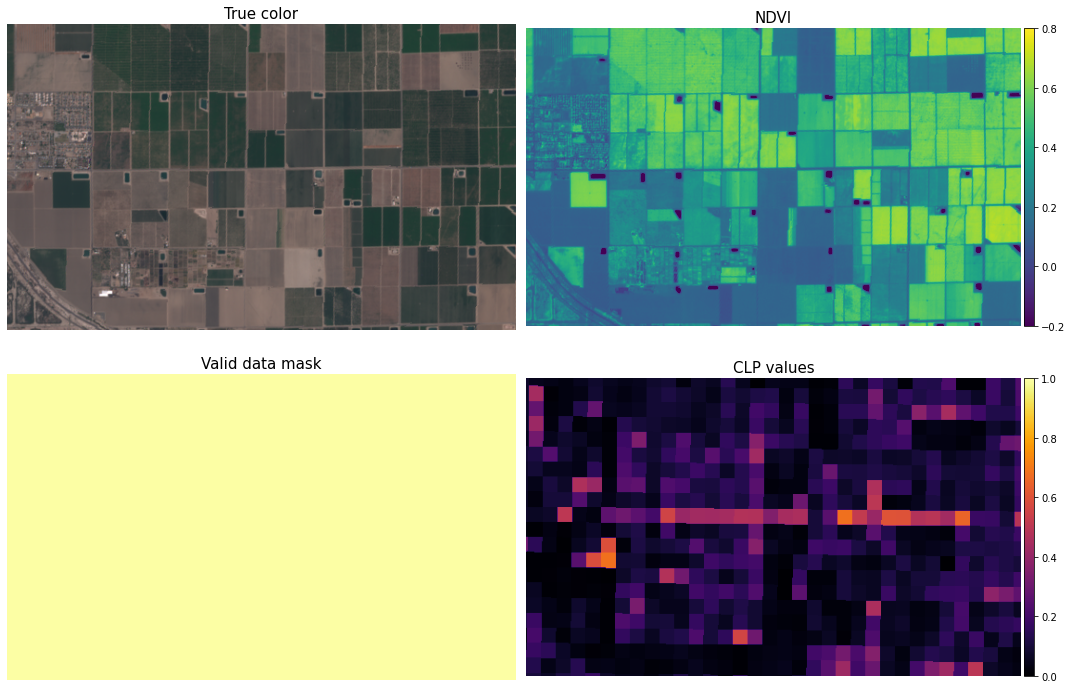

In [13]:
plot(eop_orig, np.argmax(mean_ndvi_all))

In [14]:
empty_mask = np.zeros_like(masked_ndvi_orig)

# values for a field
field1_mask = (slice(None), slice(0, 66), slice(120, 200))
mean_ndvi_feature1 = ma.mean(masked_ndvi_orig[field1_mask],axis=(1,2))
std_ndvi_feature1  = ma.std(masked_ndvi_orig[field1_mask],axis=(1,2))

# # values for another field
field2_mask = (slice(None), slice(70, 150), slice(340, 360))
mean_ndvi_feature2 = ma.average(masked_ndvi_orig[field2_mask],axis=(1,2))
std_ndvi_feature2  = ma.std(masked_ndvi_orig[field2_mask],axis=(1,2))

# # values for a city
city_mask = (slice(None), slice(74, 140), slice(0, 80))
mean_ndvi_feature3 = ma.average(masked_ndvi_orig[city_mask],axis=(1,2))
std_ndvi_feature3  = ma.std(masked_ndvi_orig[city_mask],axis=(1,2))

Text(0.5, 1.0, 'Original NDVI values, averaged per timestamp')

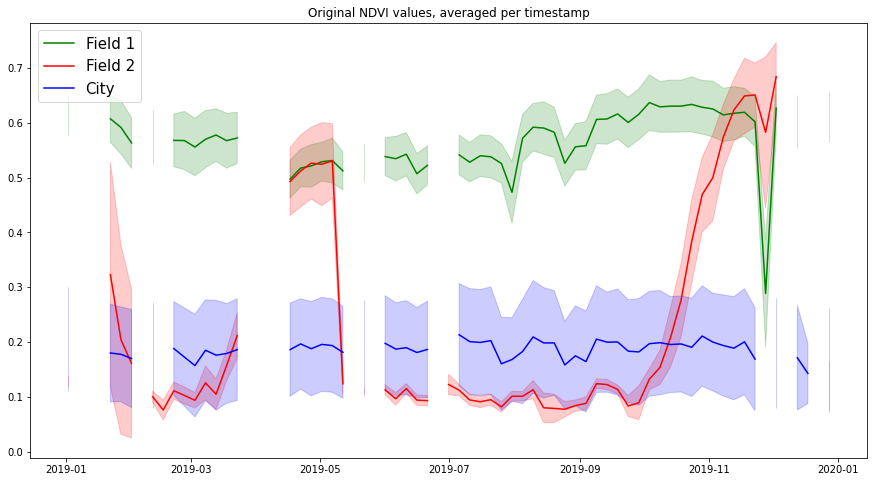

In [15]:
fig = plt.figure(figsize=(15,8))

plt.plot(eop_orig.timestamp, mean_ndvi_feature1,color='g', label='Field 1')
plt.fill_between(eop_orig.timestamp, mean_ndvi_feature1.squeeze()+std_ndvi_feature1.squeeze(),mean_ndvi_feature1.squeeze()-std_ndvi_feature1.squeeze(),alpha=0.2,color='g')

plt.plot(eop_orig.timestamp, mean_ndvi_feature2,color='r', label='Field 2')
plt.fill_between(eop_orig.timestamp, mean_ndvi_feature2.squeeze()+std_ndvi_feature2.squeeze(),mean_ndvi_feature2.squeeze()-std_ndvi_feature2.squeeze(),alpha=0.2,color='r')

plt.plot(eop_orig.timestamp, mean_ndvi_feature3,color='b', label='City')
plt.fill_between(eop_orig.timestamp, mean_ndvi_feature3.squeeze()+std_ndvi_feature3.squeeze(),mean_ndvi_feature3.squeeze()-std_ndvi_feature3.squeeze(),alpha=0.2,color='b')

plt.legend(fontsize=15)
plt.title('Original NDVI values, averaged per timestamp')

## 3. Interpolating data

In this part we define the interpolation task and interpolate the data. Only values where the `VALID_DATA` mask is `True` are taken into account.

More information about the `BSplineInterpolation` can be found [here](https://eo-learn.readthedocs.io/en/latest/_modules/eolearn/features/interpolation.html#BSplineInterpolation).

In [16]:
interp_task = BSplineInterpolation((FeatureType.DATA, 'NDVI'), mask_feature=(FeatureType.MASK, 'VALID_DATA'), 
                                   resample_range=('2019-01-01', '2019-12-30', 7),
                                   spline_degree=3)

eop = interp_task(eop_orig)
eop

EOPatch(
  data: {
    NDVI: numpy.ndarray(shape=(52, 321, 534, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((-116.07124, 33.55431), (-116.01335, 33.58277)), crs=CRS('4326'))
  timestamp: [datetime.datetime(2019, 1, 1, 0, 0), ..., datetime.datetime(2019, 12, 24, 0, 0)], length=52
)

In [17]:
ndvis = eop.data['NDVI']
empty_mask = np.zeros_like(ndvis)

# values for a field
field1_mask = (slice(None), slice(0, 66), slice(120, 200))
mean_ndvi_feature1 = ma.mean(ndvis[field1_mask],axis=(1,2))
std_ndvi_feature1  = ma.std(ndvis[field1_mask],axis=(1,2))

# # values for another field
field2_mask = (slice(None), slice(70, 150), slice(340, 360))
mean_ndvi_feature2 = ma.average(ndvis[field2_mask],axis=(1,2))
std_ndvi_feature2  = ma.std(ndvis[field2_mask],axis=(1,2))

# # values for a city
city_mask = (slice(None), slice(74, 140), slice(0, 80))
mean_ndvi_feature3 = ma.average(ndvis[city_mask],axis=(1,2))
std_ndvi_feature3  = ma.std(ndvis[city_mask],axis=(1,2))

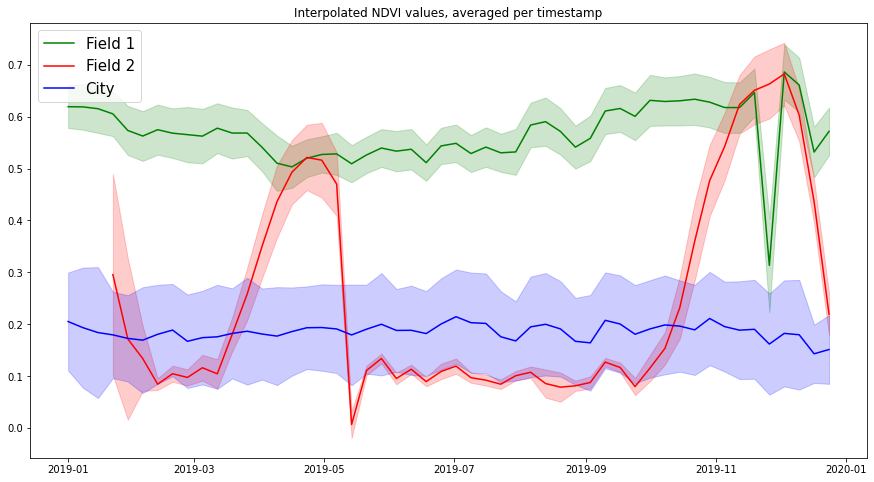

In [18]:
fig = plt.figure(figsize=(15,8))

plt.plot(eop.timestamp, mean_ndvi_feature1,color='g', label='Field 1')
plt.fill_between(eop.timestamp, mean_ndvi_feature1.squeeze()+std_ndvi_feature1.squeeze(),mean_ndvi_feature1.squeeze()-std_ndvi_feature1.squeeze(),alpha=0.2,color='g')

plt.plot(eop.timestamp, mean_ndvi_feature2,color='r', label='Field 2')
plt.fill_between(eop.timestamp, mean_ndvi_feature2.squeeze()+std_ndvi_feature2.squeeze(),mean_ndvi_feature2.squeeze()-std_ndvi_feature2.squeeze(),alpha=0.2,color='r')

plt.plot(eop.timestamp, mean_ndvi_feature3,color='b', label='City')
plt.fill_between(eop.timestamp, mean_ndvi_feature3.squeeze()+std_ndvi_feature3.squeeze(),mean_ndvi_feature3.squeeze()-std_ndvi_feature3.squeeze(),alpha=0.2,color='b')

plt.legend(fontsize=15)
plt.title('Interpolated NDVI values, averaged per timestamp');

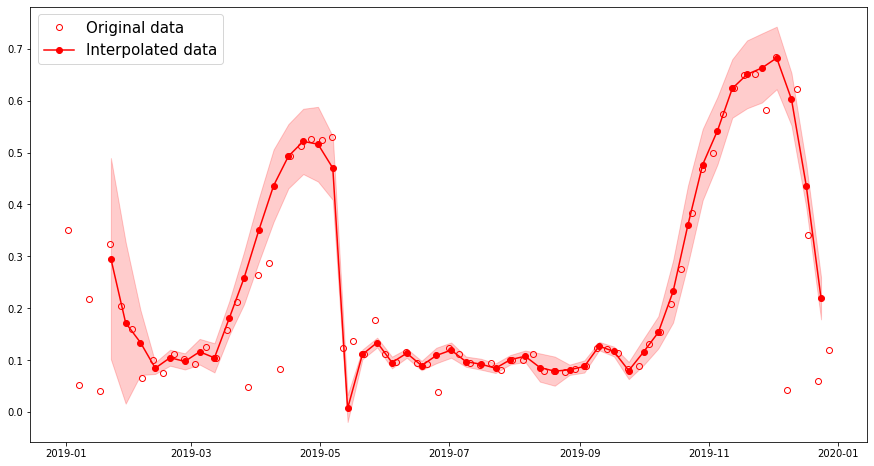

In [19]:
fig = plt.figure(figsize=(15,8))

plt.plot(eop_orig.timestamp, np.mean(eop_orig.data['NDVI'][field2_mask],axis=(1,2)),
         'o', markeredgewidth=1, markeredgecolor='r', markerfacecolor='None',label='Original data')
plt.plot(eop.timestamp, mean_ndvi_feature2,'o-',color='r',label='Interpolated data')
plt.fill_between(eop.timestamp, 
                 mean_ndvi_feature2.squeeze() + std_ndvi_feature2.squeeze(), 
                 mean_ndvi_feature2.squeeze() - std_ndvi_feature2.squeeze(), alpha=0.2, color='r')

plt.legend(fontsize=15);